In [47]:
# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
import json
import labtools

# Data Visualization
import matplotlib.pyplot as plt

import warnings
# Suppress the SettingWithCopyWarning
warnings.filterwarnings('ignore')

# Web Interaction and Display
from IPython.display import Image, display, HTML

# Additional JavaScript for toggling code display in Jupyter Notebooks
HTML(
    """
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

In [48]:
final_df = pd.read_csv('final_df.csv')

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">SUPPLEMENTARY NOTEBOOK (1995-2024 - 250 Samples)</h2>
</div>

This notebook contains the implementation of the clustering method applied to the abstracts of research publications released between 1995 and 2024.

---

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">TOKEN VECTORIZATION</h2>
</div>

This is a list of consolidated abstracts of two publications submitted between 1995 and 2024 using only 250 samples per year.

In [49]:
years = list(range(1995, 2024))
samples_per_year = 250  # Set the desired number of samples per year

samples = []
for year in years:
    year_df = final_df[final_df['year'] == year]
    # Check if the year has at least the desired number of samples
    if len(year_df) >= samples_per_year:
        sample = year_df.sample(n=samples_per_year, random_state=42)  # Ensures reproducibility
    else:
        # Option 1: Take all available samples if fewer than desired
        sample = year_df
        # Option 2: Uncomment the next line to skip years with fewer than desired samples
        # continue
    samples.append(sample)

# Concatenate the sampled DataFrames
df_250 = pd.concat(samples, ignore_index=True)

# Extract the abstracts from the sampled DataFrame
abs_250 = df_250['abstract'].tolist()

# Printing the first 2 abstracts as a check
print(abs_250[:2])

["  Multiclass learning problems involve finding a definition for an unknown\nfunction f(x) whose range is a discrete set containing k &gt 2 values (i.e., k\n``classes''). The definition is acquired by studying collections of training\nexamples of the form [x_i, f (x_i)]. Existing approaches to multiclass learning\nproblems include direct application of multiclass algorithms such as the\ndecision-tree algorithms C4.5 and CART, application of binary concept learning\nalgorithms to learn individual binary functions for each of the k classes, and\napplication of binary concept learning algorithms with distributed output\nrepresentations. This paper compares these three approaches to a new technique\nin which error-correcting codes are employed as a distributed output\nrepresentation. We show that these output representations improve the\ngeneralization performance of both C4.5 and backpropagation on a wide range of\nmulticlass learning tasks. We also demonstrate that this approach is robu

We next create a matrix representing certain words on this list as a column and their corresponding frequencies within each abstract as values in the matrix. This matrix allows for quantitative analysis of the abstracts based on the occurrence of specific keywords or terms. 

To determine the optimal values for `min_df` and `max_df`, we created a heatmap that shows the sparsity of the TF-IDF matrix for different combinations of `min_df` and `max_df` values. The sparsity is calculated as the ratio of zero elements in the matrix to the total number of elements.

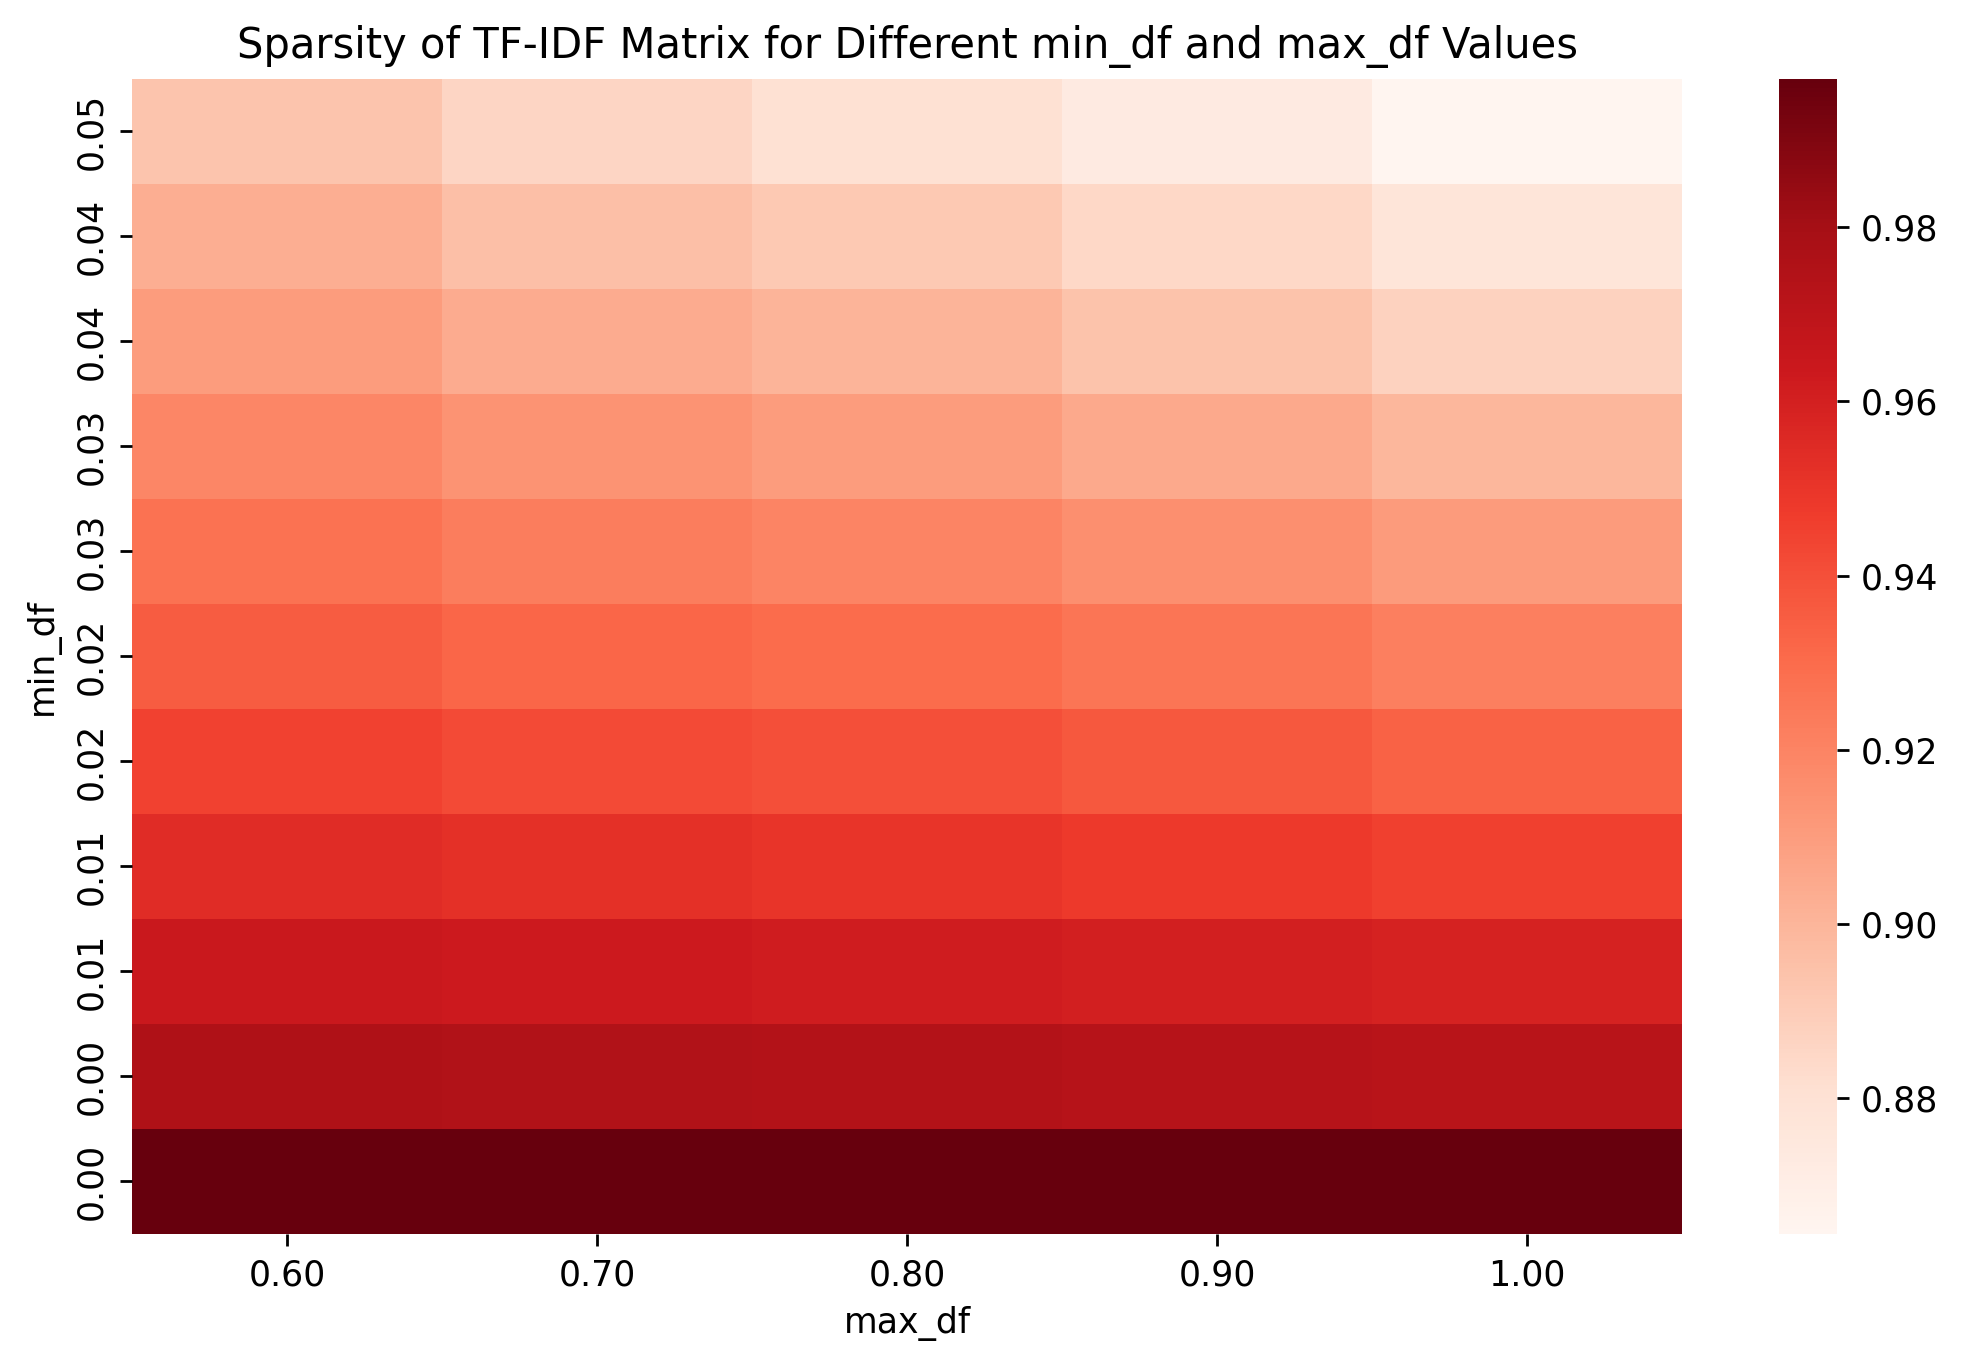

In [50]:
labtools.visualize_sparsity(abs_250)

<div style="text-align: center;">
    <h6>
        <b>Figure 1.</b> Sparsity of TF-IDF Matrix for Different <code>min_df</code> and <code>max_df</code> values
    </h6>
</div>

- **Lower right corner (high `min_df`, low `max_df`)**: This region has the lowest sparsity, indicating that most terms are included in the vocabulary due to the lenient filtering.
- **Upper left corner (low `min_df`, high `max_df`)**: This region has the highest sparsity, indicating that many terms have been excluded from the vocabulary due to the aggressive filtering of rare and common terms.
- **Diagonal trend**: As you move from the upper left corner to the lower right corner, the sparsity generally increases. This is because increasing `min_df` and decreasing `max_df` results in more aggressive filtering of the vocabulary.

The heatmap highlights the trade-off between sparsity and vocabulary size. A sparser matrix (higher sparsity) may be more computationally efficient, but it may also exclude important terms. A denser matrix (lower sparsity) includes more terms but may also include noise.

We chose the middle of the heatmap as the optimal region for the values of `min_df` and `max_df`, indicating a balance between including informative terms and excluding noise.

Let's also remove English and context-specific stopwords. Our resulting matrix looks like this:

In [51]:
df_tfidf_250 = labtools.vectorize_abstract(abs_250, min_df=0.03, max_df=0.8)
df_tfidf_250.head(3)

accuracy  achieve  addition  address  algorithm  algorithms  analysis  \
0         0        0         0        0          0    0.268643         0   
1         0        0         0        0   0.342799    0.128599         0   
2         0        0         0        0          0    0.184143         0   

   applied     apply  approaches  ...      tree  underlying  uniform  \
0        0         0    0.157632  ...  0.182938           0        0   
1        0  0.158879           0  ...         0           0        0   
2        0         0           0  ...         0           0        0   

    unknown  upper    values  variable  variables  variance  weak  
0  0.090772      0  0.080344         0          0         0     0  
1         0      0         0         0          0         0     0  
2         0      0         0         0          0         0     0  

[3 rows x 276 columns]

<div style="text-align: center;">
    <h6>
        <b>Table 1.</b> TF-IDF Matrix
    </h6>
</div>


<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">DIMENSIONALITY REDUCTION</h2>
</div>

Next, we reduce the complexity of the dataset by decreasing the number of its dimensions. We first determine the number of singular vectors that would give us at least 90% of the variance explained using the `TruncatedSVD` method.

Number of components for at least 90% variance explained: 217


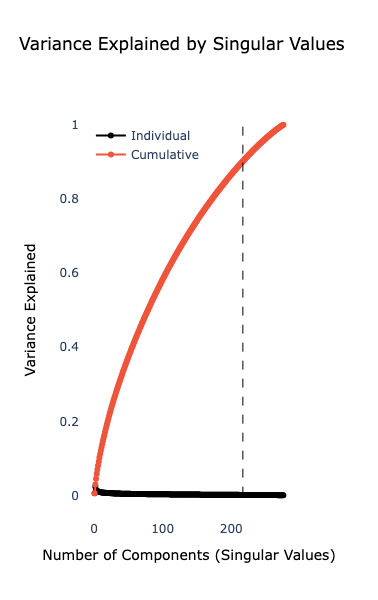

217

In [52]:
labtools.get_n_components(df_tfidf_250, show_viz=True)

<div style="text-align: center;">
    <h6>
        <b>Figure 2.</b> Individual and Cumulative Variance Explained of the SV Components
    </h6>
</div>


We then proceed to reducing the number of dimensions of our dataset based on the initial check.

In [53]:
reduced_250 = labtools.reduce_dimensions(labtools.get_n_components(df_tfidf_250, 
                                                         show_viz=False),
                                        df_tfidf_250)

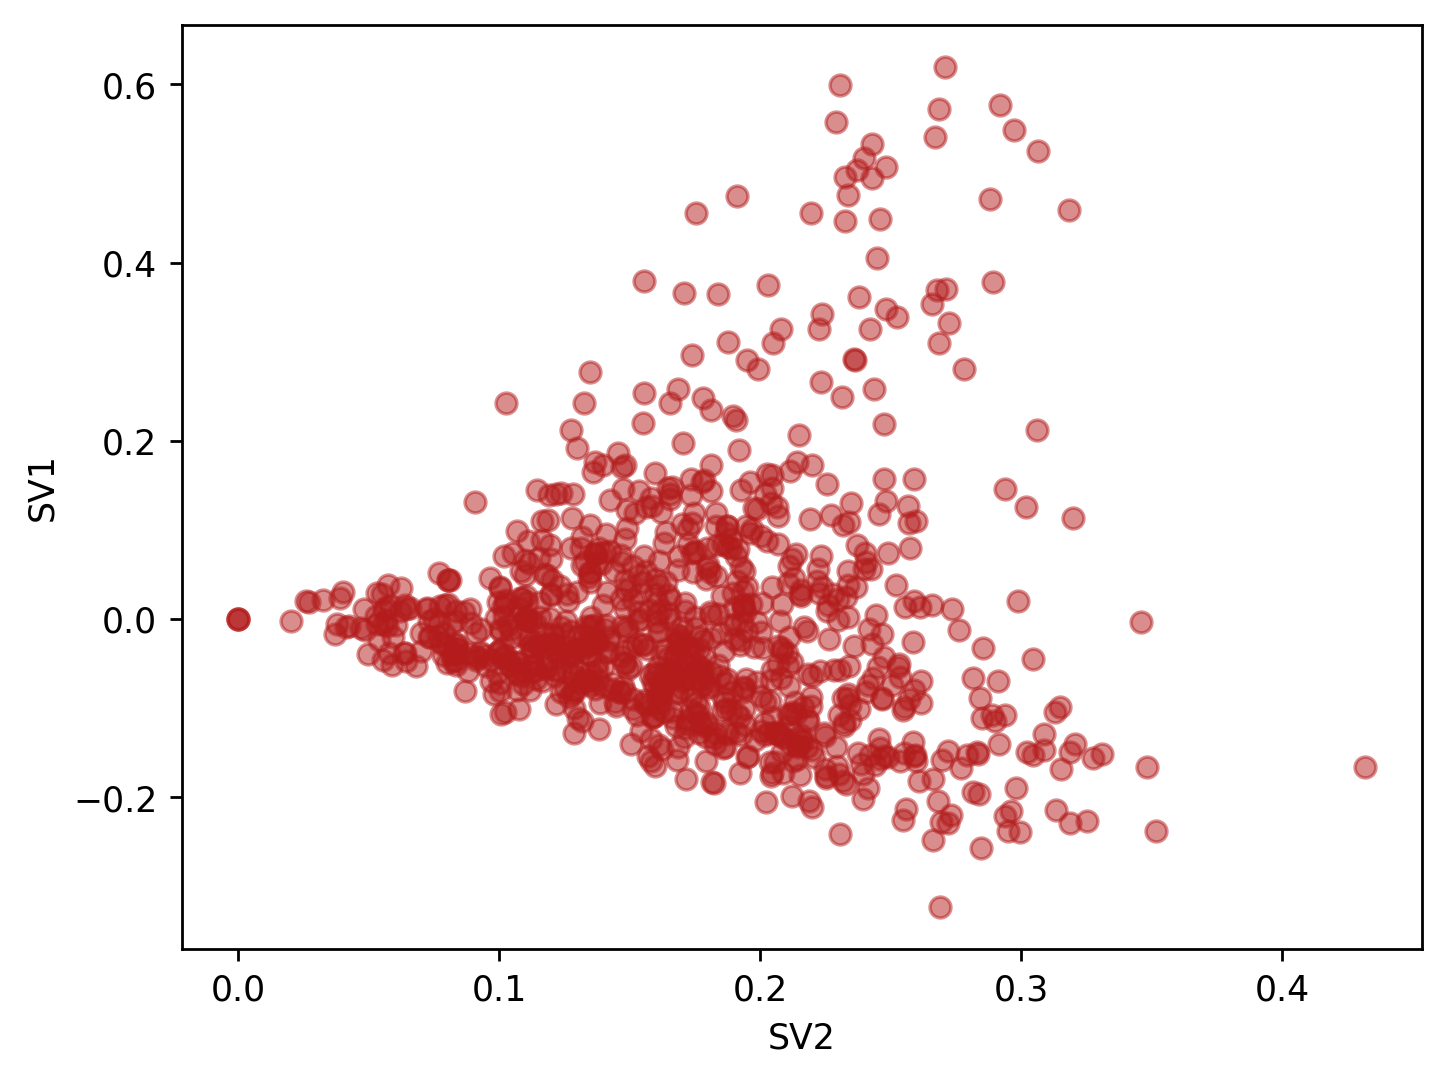

In [54]:
plt.figure(dpi=250)
plt.scatter(reduced_95[:, 0], reduced_95[:, 1], alpha=0.5, color='#b41c1c')
plt.xlabel('SV2')
plt.ylabel('SV1');

<div style="text-align: center;">
    <h6>
        <b>Figure 3.</b> The TF-IDF as projected to the first two singular vectors
    </h6>
</div>


The scatter plot of the first two singular vectors for the 250 samples reveals a dense core where data points cluster closely together, with several outliers extending away from the center. This pattern suggests that while there may be a strong central theme or commonality shared among many of the samples, there are also distinct variations or unique topics that branch out from the main group.

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">CLUSTERING</h2>
</div>


Optimal number of clusters: 2
Threshold distance: 8.024396


8.0243964110883

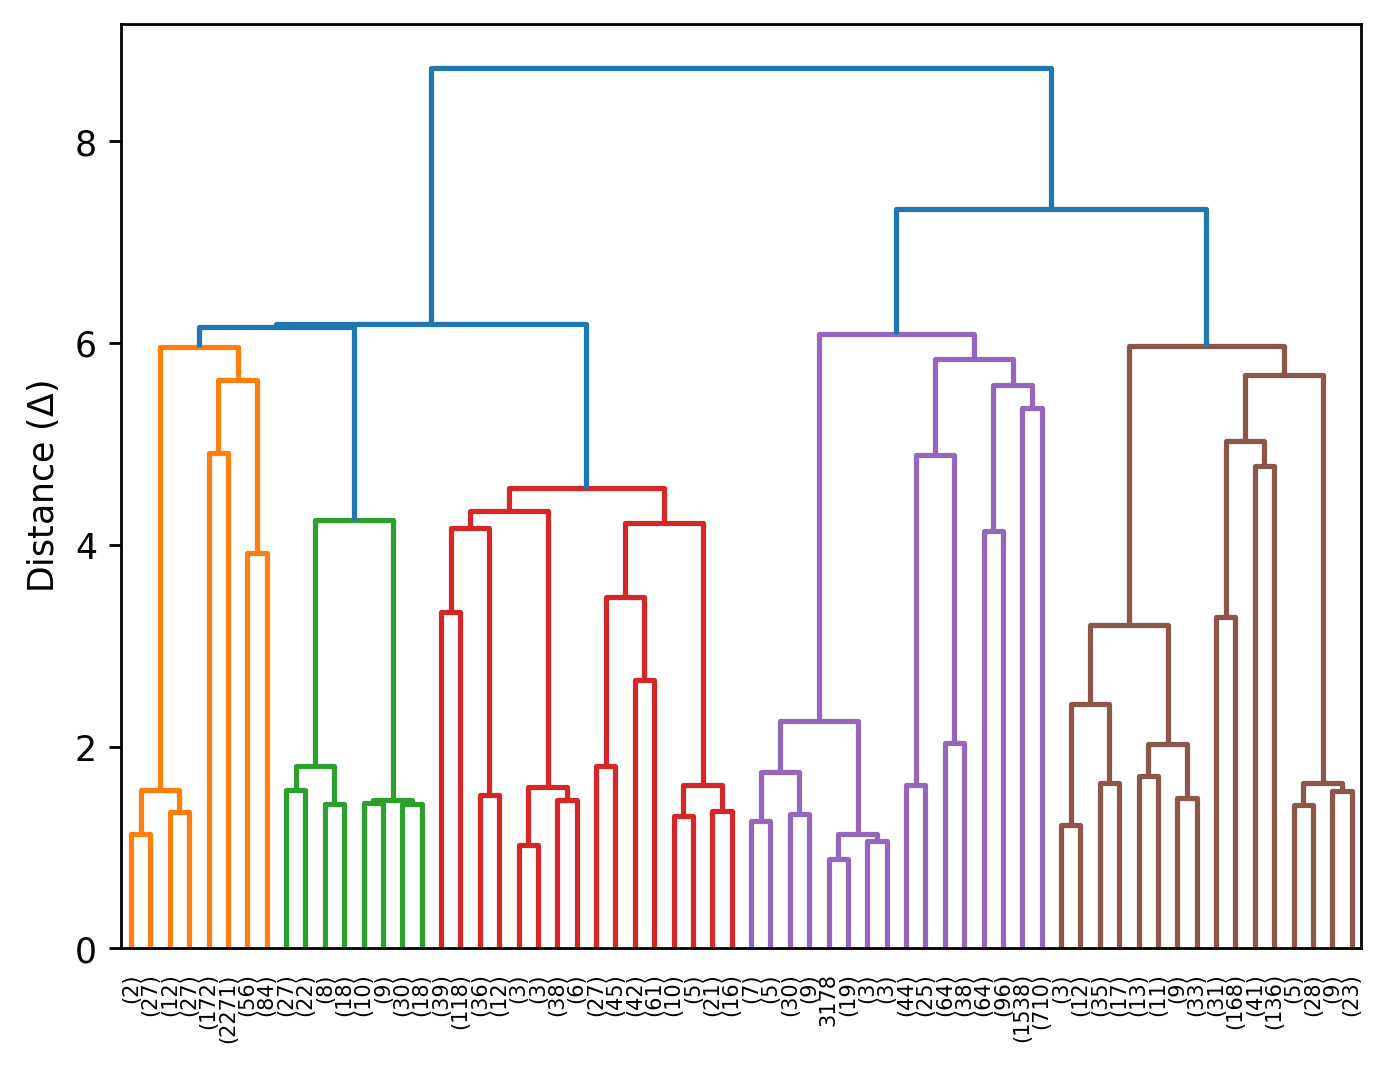

In [55]:
labtools.hierarchical_clustering(reduced_250)

<div style="text-align: center;">
    <h6>
        <b>Figure 4.</b> Ward's Clustering Dendrogram Results
    </h6>
</div>


From the dendrogram, we see that the optimal number of clusters is two. However, it would be interesting to investigate the sub-clusters that were formed under each main cluster because we can see that one main cluster has more points, so it is possible that we can further find subgroups under it. Let's check these both.

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">EDA on Main Clusters</h2>
</div>


Let's first check the two main clusters. This is what it looks when projected on the first two singular vectors:

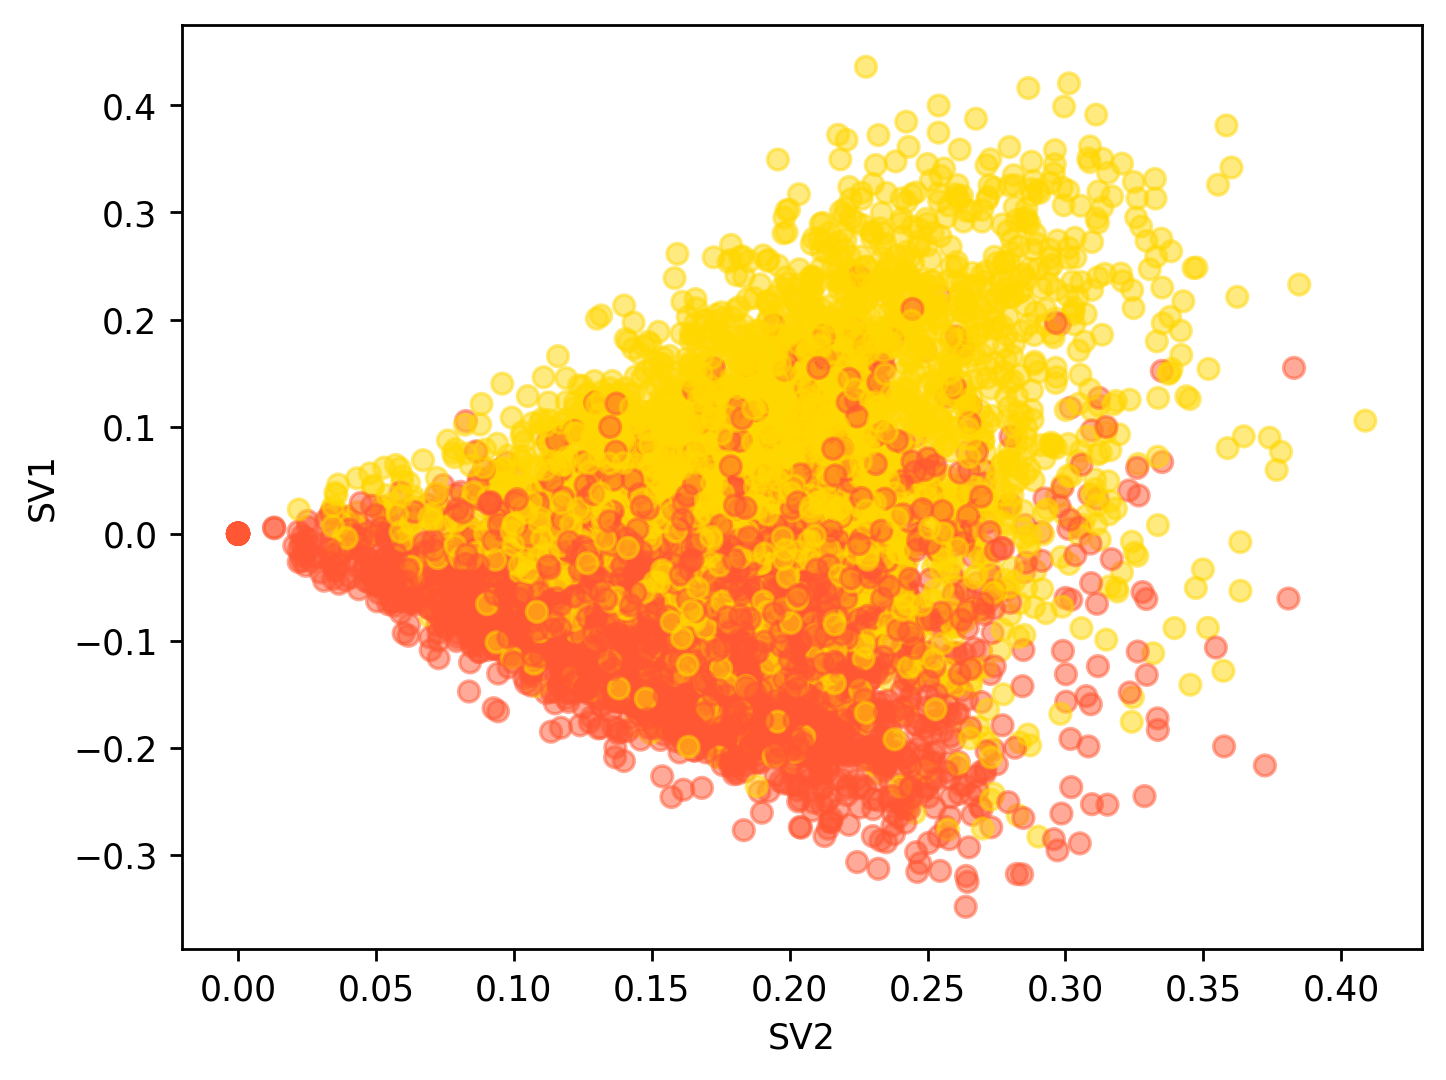

In [56]:
labtools.cluster_predict(reduced_250, df_250, show_viz=True)

<div style="text-align: center;">
    <h6>
        <b>Figure 5.</b> Clustering Results as Projected on the First Two Singular Vectors
    </h6>
</div>

The scatter plot with color gradation from red to yellow for the 250 samples indicates a density gradient, we can assume that it is possibly corresponding to the frequency or importance of certain topics within the dataset. The red, denser area represents a core concentration of common themes, while the yellow, sparser area may depict less common or emerging topics within the field.

Let's visualize the abstracts of the publications belonging to each main cluster using a word cloud to have an idea on what the cluster is all about.

In [57]:
clustered_df = labtools.cluster_predict(reduced_250, df_250, show_viz=False,
                               get_updated_df=True)

#### Cluster 1: 1995-2024 - 250 Samples

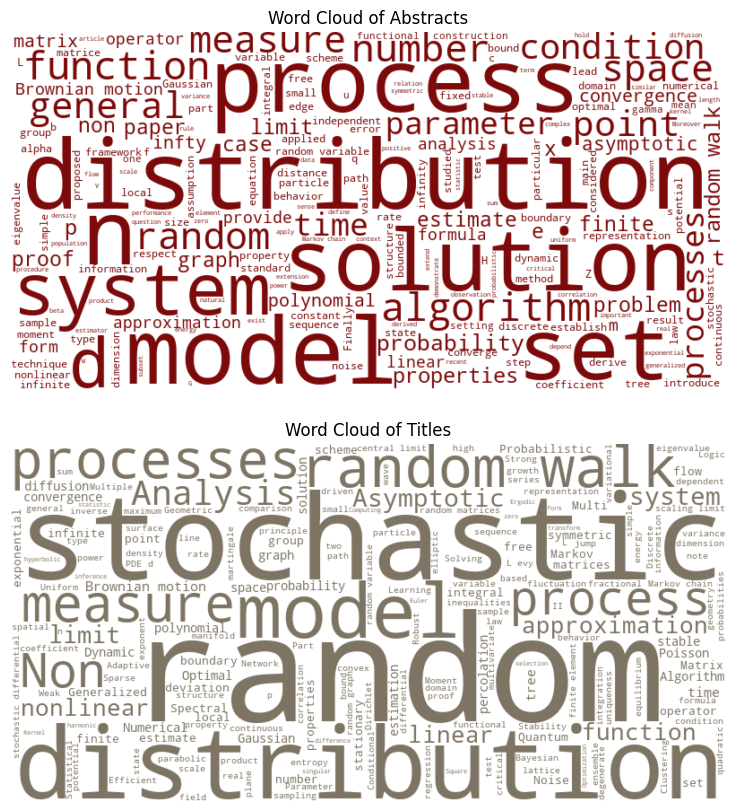

In [58]:
labtools.generate_wordclouds(clustered_df, cluster_number=1)

<div style="text-align: center;">
    <h6>
        <b>Figure 6.</b> Word Cloud of Main Cluster 1
    </h6>
</div>

#### Cluster 2: 1995-2024 - 250 Samples

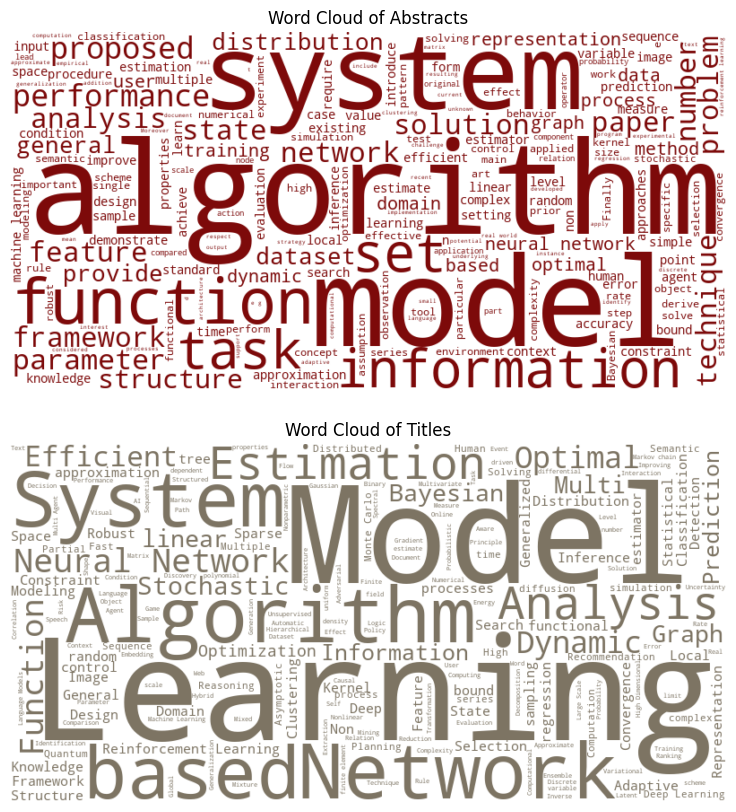

In [59]:
labtools.generate_wordclouds(clustered_df, cluster_number=2)

<div style="text-align: center;">
    <h6>
        <b>Figure 7.</b> Word Cloud of Main Cluster 2
    </h6>
</div>

**How imbalanced are our main clusters between 1995 and 2024?**

As we can see, Cluster 2 is almost equal to Cluster 1. However, it could still be worth investigating its sub-clusters considering how general the current clustering is. 

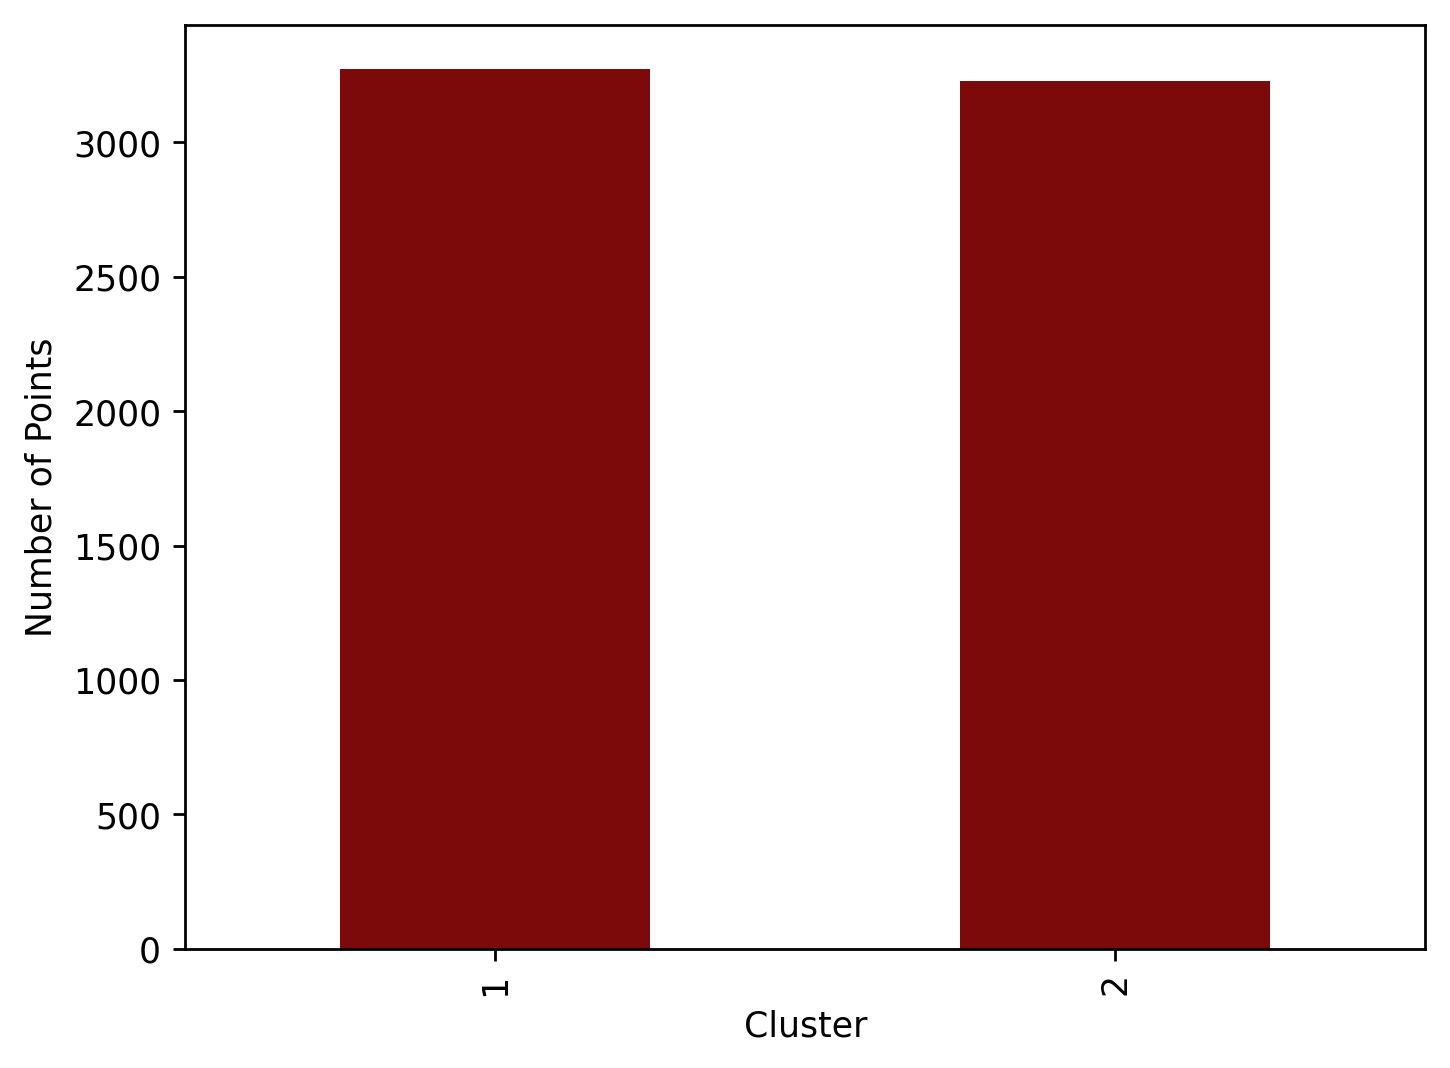

In [60]:
plt.figure(dpi=250)
clustered_df.cluster.value_counts().plot(kind='bar', color='#7d0a0a',
                                         xlabel='Cluster',
                                         ylabel='Number of Points');

<div style="text-align: center;">
    <h6>
        <b>Figure 8.</b> Visualizing the Distribution of Points to the Initial Clusters
    </h6>
</div>

#### Subclustering

To do this, we refer back to our dendrogram and change our threshold so that we would capture the subclusters of the large main cluster. Through eyeballing it, a threshold of 3.3 would suffice. The resulting distribution looks like this:

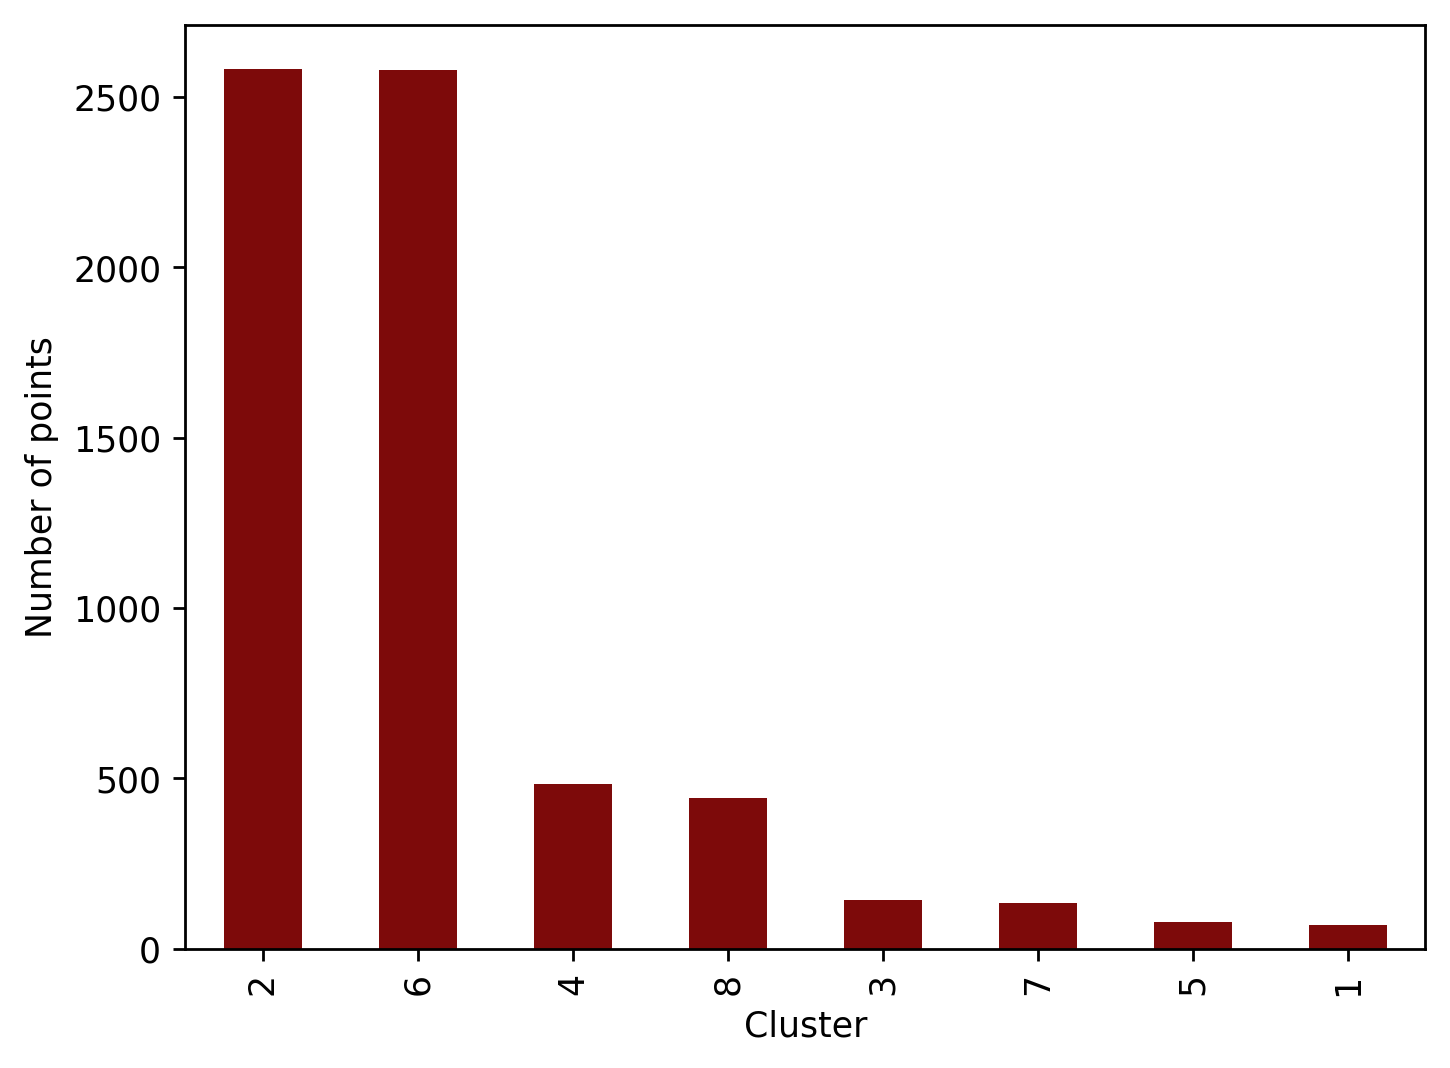

In [69]:
clustered_df = labtools.cluster_predict(reduced_250, df_250, show_viz=False, 
                               get_updated_df=True, thres=5.9)

plt.figure(dpi=250)
clustered_df.cluster.value_counts().plot(kind='bar', color='#7d0a0a', 
                                         xlabel='Cluster',
                                         ylabel='Number of points');

<div style="text-align: center;">
    <h6>
        <b>Figure 9.</b> Visualizing the Distribution of Points after Re-clustering
    </h6>
</div>

Here, two cluster dominates the others with respect to the number of points, the general distribution of the points improved. Let's see what words compose each of these clusters.

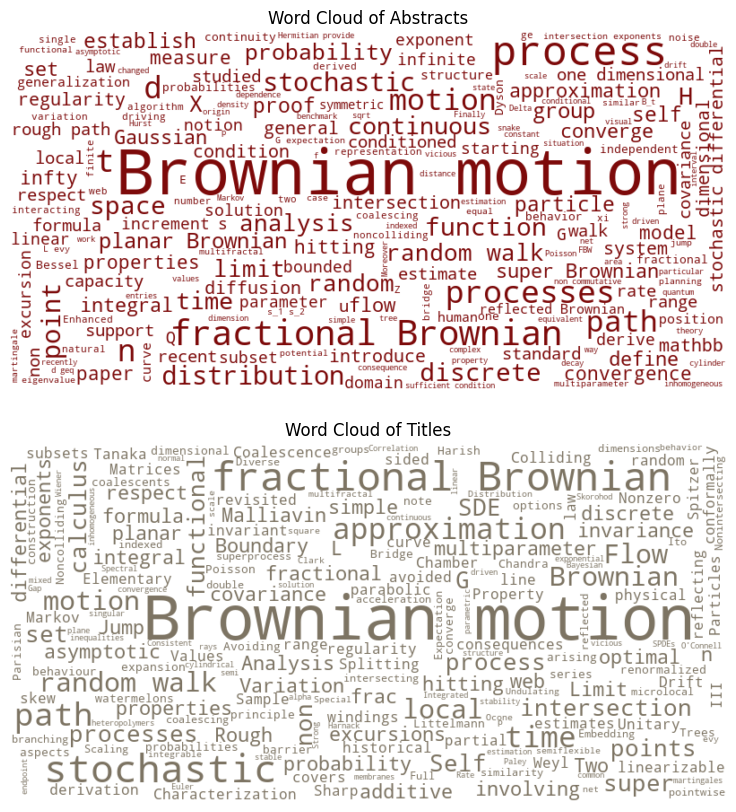

In [70]:
# Sub-Cluster 1: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=1)

<div style="text-align: center;">
    <h6>
        <b>Figure 10.</b> Word Cloud of Final Cluster 1
    </h6>
</div>

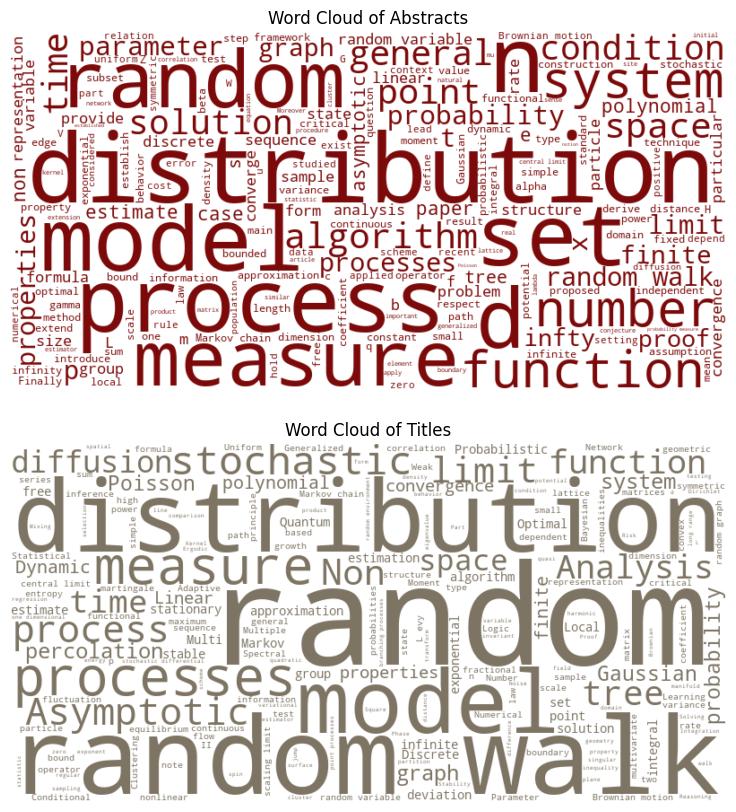

In [71]:
# Sub-Cluster 2: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=2)

<div style="text-align: center;">
    <h6>
        <b>Figure 11.</b> Word Cloud of Final Cluster 2
    </h6>
</div>

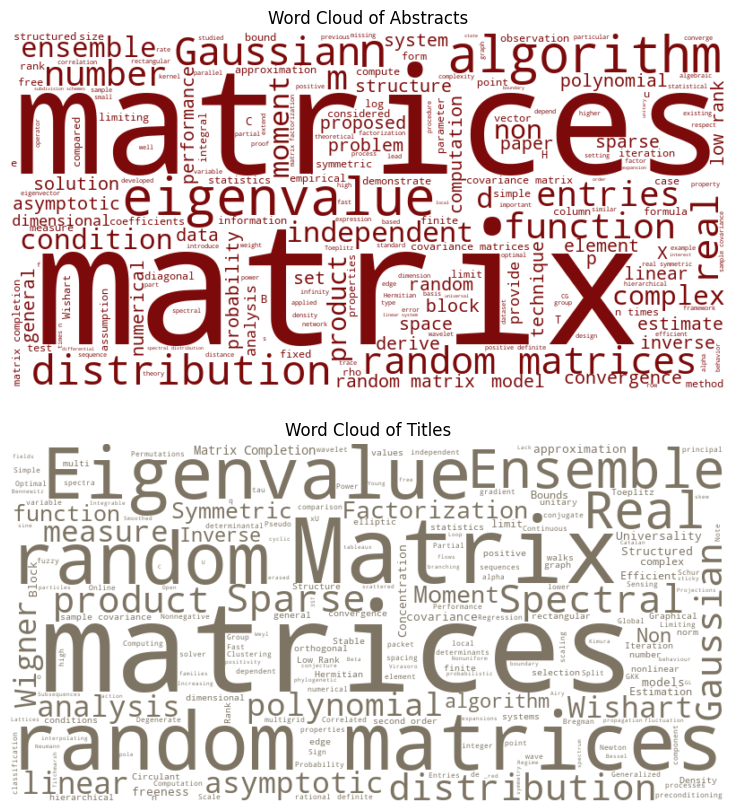

In [72]:
# Sub-Cluster 3: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=3)

<div style="text-align: center;">
    <h6>
        <b>Figure 12.</b> Word Cloud of Final Cluster 3
    </h6>
</div>

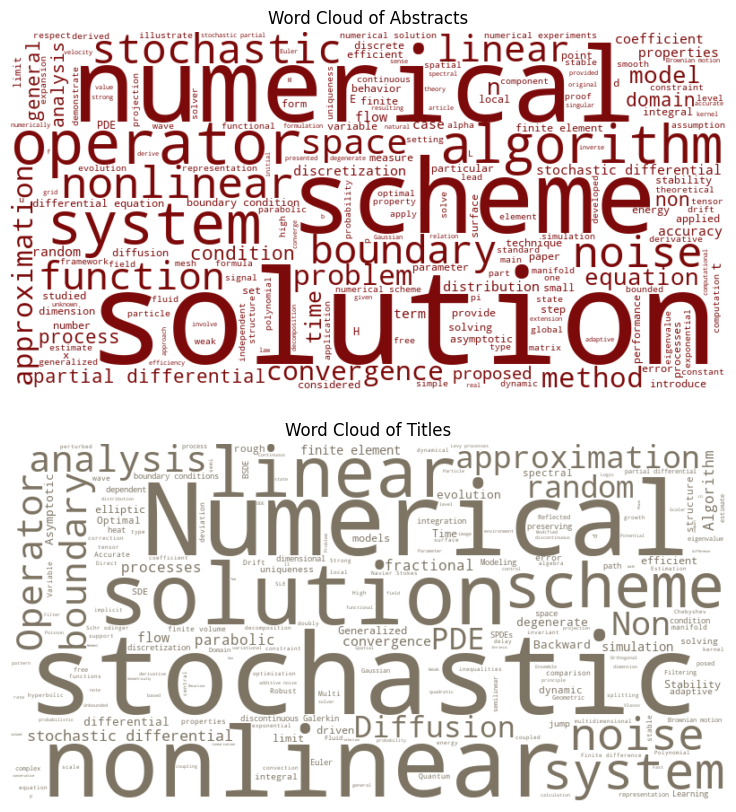

In [73]:
# Sub-Cluster 4: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=4)

<div style="text-align: center;">
    <h6>
        <b>Figure 13.</b> Word Cloud of Final Cluster 4
    </h6>
</div>

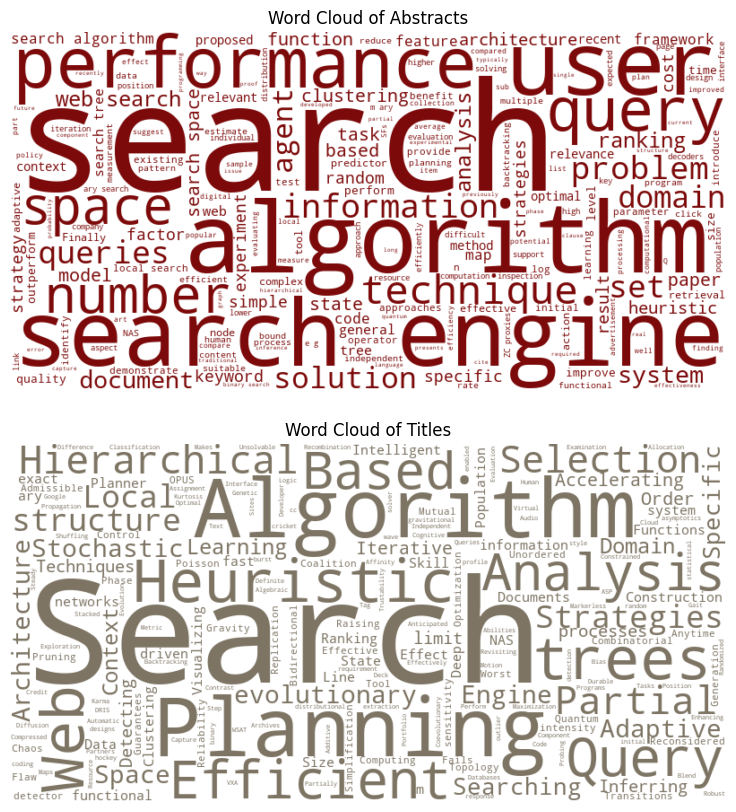

In [74]:
# Sub-Cluster 5: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=5)

<div style="text-align: center;">
    <h6>
        <b>Figure 14.</b> Word Cloud of Final Cluster 5
    </h6>
</div>

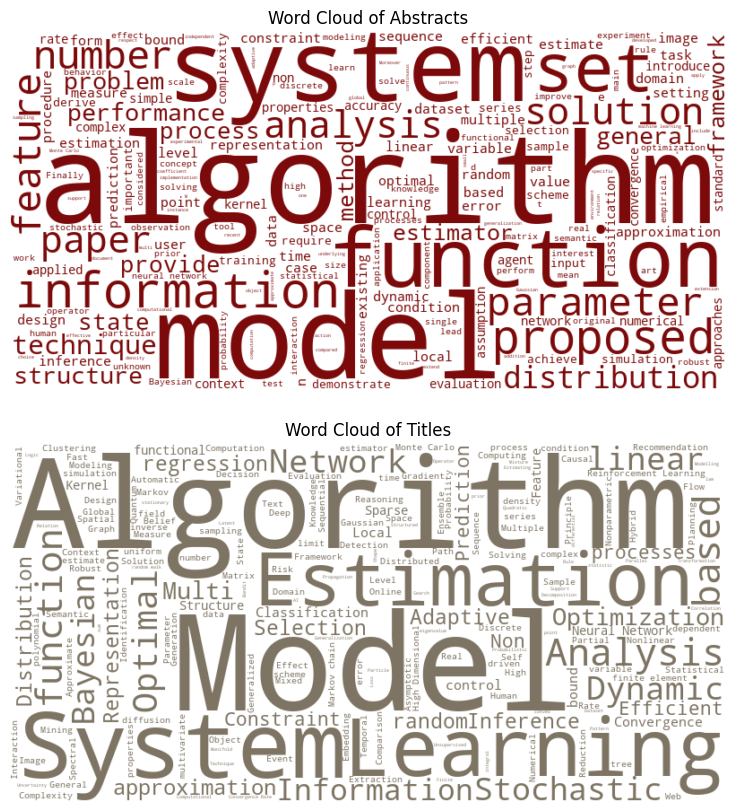

In [75]:
# Sub-Cluster 6: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=6)

<div style="text-align: center;">
    <h6>
        <b>Figure 15.</b> Word Cloud of Final Cluster 6
    </h6>
</div>

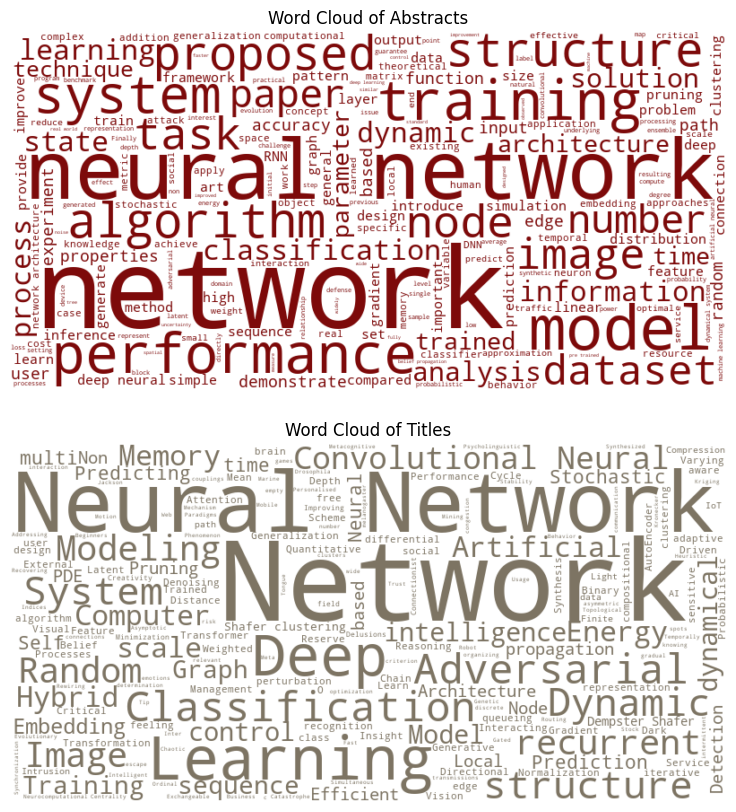

In [76]:
# Sub-Cluster 7: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=7)

<div style="text-align: center;">
    <h6>
        <b>Figure 16.</b> Word Cloud of Final Cluster 7
    </h6>
</div>

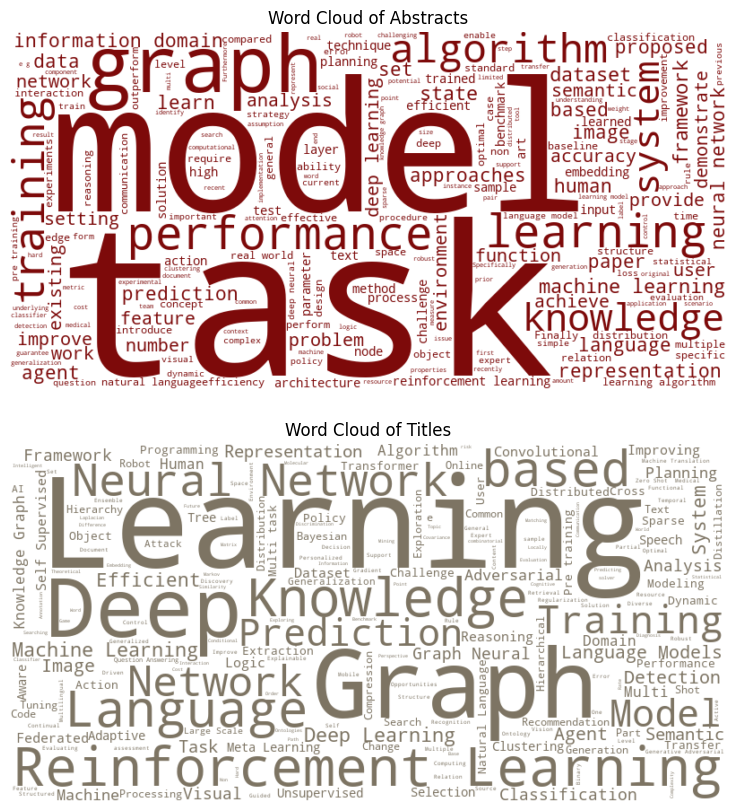

In [77]:
# Sub-Cluster 8: 1995-2024 - 250 Samples
labtools.generate_wordclouds(clustered_df, cluster_number=8)

<div style="text-align: center;">
    <h6>
        <b>Figure 17.</b> Word Cloud of Final Cluster 8
    </h6>
</div>

<div style="background-color:#711012; text-align:center; padding: 10px 0;">
    <h2 style="color: white; font-weight:bold">CLUSTER INTERPRETATION and INSIGHTS</h2>
</div>

### *Main Clusters*

#### *Cluster 1: Computational Theories and Statistical Frameworks in Data Science*

- *Abstract Keywords*: "Function", "Distribution", "Random", "Algorithm", And "System"
- *Title Keywords*: "Stochastic", “Random Walk”, “Distribution”, “Random”, “Analysis”, and “Approximation”
- *Interpretation*:
  - With prominent terms like "function," "distribution," "random," "algorithm," and "system," this cluster reflects the interdisciplinary nexus of computer science, mathematics, and applied statistics.
- *Insights*:
  - The first cluster may represent a more theoretically oriented body of work, possibly dealing with the foundational aspects of mathematics and statistics, as indicated by big words like “function”, “distribution”, and “algorithm”, and by small words which are "Brownian motion" and "stochastic processes." 
  - The cluster underscores a research landscape where mathematical rigor meets computational innovation, and where probabilistic and statistical frameworks are pivotal in deciphering complex systems. This fusion points to a data science research community that is deeply engaged in theoretical development, computational problem-solving, and practical application of statistical models.

#### *Cluster 2: Algorithmic Efficiency and Network Modeling*

- *Abstract Keywords*: "Algorithm", "Network", "Estimation", "Dynamic", And "Optimization"
- *Title Keywords*: "Learning", “System”, “Model”, “Network”, “Neural Network”, and “Algorithm”
  - This cluster, highlighted by terms such as "algorithm," "network," "estimation," "dynamic," and "optimization," captures the essence of research focused on the development and refinement of algorithms within the realms of network analysis and dynamic systems. 
- *Insights*:
  - The second cluster seems to emphasize computational and algorithmic research, as suggested by terms like "algorithm", "system", and "model". This cluster has a significant concentration on optimizing performance, estimating parameters, and analyzing the robustness of various systems. 
  - The prominence of "neural network" and "framework" alongside " classification " and "regression" suggests a strong inclination towards the use of machine learning methods and probabilistic models through algorithm techniques to tackle complex, data-intensive problems. This cluster represents a segment of data science that is particularly concerned with the practical aspects of algorithm application, efficiency in computational tasks, and the modeling of adaptive, intelligent systems.

### *Sub-Clusters*

#### *Sub-Cluster Label 1: Stochastic Calculus and Theoretical Physics*

- *Abstract Keywords*: “Brownian Motion”, "Random Walk", "Discrete", "Convergence", "Stochastic Differential", And "Distribution"
- *Title Keywords*: “Differential”, “Brownian Motion”, “Variation”, “Drift”, “Stochastic” and “Approximation”
- *Interpretation*:
  - This sub-cluster focuses on the mathematical underpinnings of random processes, with a strong emphasis on Brownian motion, fractional calculus, and their applications in physics and finance.
- *Insights*:
  - The sub-cluster delves into randomness and complexity in physical systems, possibly connecting statistical mechanics and mathematical finance with the support of Data Science methods.

#### *Sub-Cluster Label 2: Numerical Methods and Stochastic Analysis*

- *Abstract Keywords*: “Function”, "Random Walk", "Algorithm", "Estimate", And "Distribution"
- *Title Keywords*: “Random”, “Random Walk”, “Limit”, “Distribution”, “Stochastic” and “Asymptotic”
- *Interpretation*:
  - This sub-cluster centers around computational techniques for analyzing random systems and processes, with an emphasis on numerical solutions and the evaluation of stochastic models.
- *Insights*:
  - This sub-cluster focuses on the simulation and computational aspects of stochastic processes, this has the largest number of studies across the span of 30 years with respect to the sub-cluster results.

#### *Sub-Cluster Label 3: Random Matrices and Eigenvalue Distributions*

- *Abstract Keywords*: “Matrix”, "Matrices", "Eigenvalues", "Random Matrices", and "Algorithm"
- *Title Keywords*: “Eigenvalues”, “Matrix”, “Matrices”, “Random Matrices”, “Sparse” and “Matrix Completion”
- *Interpretation*:
  - This sub-cluster deals with the study of matrix theory and spectral analysis, particularly exploring the properties of random matrices and their eigenvalue distributions in various fields.
- *Insights*:
  - This sub-cluster concentrates on the properties of matrices, particularly in relation to eigenvalues and eigenvectors, which is supported by data science concepts. This field of study is important in many areas of physics and engineering.

#### *Sub-Cluster Label 4: Artificial Intelligence and Data Architecture*

a.	Cluster words on Abstract: “Numerical”, "Scheme", "Boundary", "Tensor", And "Efficiency"

b.	Cluster words on Titles: “Nonlinear”, “Analysis”, “Numerical”, “Solution”, “Stochastic” and “Algorithm”

c.	Interpretation: This sub-cluster relates to the field of artificial intelligence, exploring neural network architectures, deep learning, and the structural design of systems for advanced data processing.

d.	Inference: This sub-cluster dives into the design and application of AI, including neural networks and deep learning models, for advanced problem-solving – all of which are emerging Data Science topics and this sub-cluster represent how large the number of studies published in this field of study across the sample.


#### *Sub-Cluster Label 5: Information Retrieval and Semantic Search*

- *Abstract Keywords*: “Search”, "Query", "Search Engine", "User", And "Algorithm"
- *Title Keywords*: “Search”, “Hierarchical”, “Query”, “Searching”, “Web” and “Algorithm”
- *Interpretation*:
  - This sub-cluster highlights the development and analysis of algorithms designed to operate in high-dimensional spaces, tackling problems related to search optimization, sampling, and data representation, and manipulation.
- *Insights*:
  - This sub-cluster deals with the challenges of working with high-dimensional data sets, including optimization and dimensionality reduction techniques which are linked to data science sub-fields such as data mining, wrangling, and analysis, and mathematical concepts that backs the field.

#### *Sub-Cluster Label 6: Algorithmic Development and System Optimization*

- *Abstract Keywords*: “Function”, "Parameter", "Distribution", "Model", And "Algorithm"
- *Title Keywords*: “Model”, “System”, “Learning”, “Estimation”, “Dynamic” and “Algorithm”
- *Interpretation*:
  - This sub-cluster concentrates on the creation and refinement of algorithms for system optimization, featuring techniques that enhance computational efficiency and problem-solving.
- *Insights*:
  - This sub-cluster focuses on enhancing algorithmic efficiency aspect of Data Science, which is likely in the context of faster computation and better model performance in solving industry or domain-specific complex problems.

#### *Sub-Cluster Label 7: Graph Theory and Network Dynamics*

- *Abstract Keywords*: “Graph”, " Neural Network ", "Model", " Network ", And "Algorithm"
- *Title Keywords*: “Learning”, “Graph”, “Neural Network”, “Convolutional”, “Neural” and “Dynamic”
- *Interpretation*:
  - This sub-cluster focuses on the study of networks and graphs, applying principles of graph theory to understand the dynamics and structures of complex networked systems.
- *Insights*:
  - This sub-cluster explores the structure and dynamics of networks, that is key in understanding complex systems which is linked to the field of Data Science. Its use in the industry or other field of studies ranges from social networks to biological systems.

#### *Sub-Cluster Label 8: Machine Learning and Predictive Modelling*

- *Abstract Keywords*: “Task”, "Model", "Performance", "Learning", And "Machine Learning"
- *Title Keywords*: “Learning”, “Model”, “Prediction”, “Machine Learning”, “Tuning” and “Algorithm”
- *Interpretation*:
  - This cluster revolves around machine learning techniques, emphasizing predictive modeling, algorithmic learning, and performance evaluation in data-rich environments.
- *Insights*:
  - This sub-cluster is made up of studies that explores various machine learning techniques for prediction, highlighting the role of data-driven models in forecasting and decision-making under the field of study of Data Science.